# Load model inputs 

This notebook downloads model output from the figshare collection: https://figshare.com/s/a3e9a208108d91d75f72

Variable `X` is full coverage while `X_socat` is only sampled at SOCAT locations.

- The game we are playing is estimate pCO2 using SST, SSS, CHL, MLD, and xCO2 (driver data)
- Pretend this is real data. So you can only use pCO2 sampled like SOCAT (i.e. pCO2_socat) to train model
- But you can use the full coverage of driver data however you wish, because that is what you have in the real world. I provide the driver data sampled at SOCAT because this may be convenient when training a neural network.
- Think of a baseline model. Linear regression? Multiple linear regression? 
- Once you make make some estimates at the locations with holes, you can compare your estimates to the "true" value (i.e. `pCO2` in the dataset)

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cm

In [2]:
print(f'xarray {xr.__version__}')
print(f'numpy {np.__version__}')
print(f'matplotlib {mpl.__version__}')
print(f'cartopy {cartopy.__version__}')
print('cmocean 1.1') ### From `conda list` I do not know how to display the version

xarray 0.10.9
numpy 1.15.4
matplotlib 2.2.3
cartopy 0.16.0
cmocean 1.1


# Function to make nice maps
Please feel free to improve this. It could be better

In [3]:
class SpatialMap(object):
    """
    Spatial Map
    Plot data on a world map centerted at 157.5 deg
    * set_ticks
    * set_title
    * set_cbar_title
    """

    def __init__(self, data, lon=np.arange(0.5,360,1), lat=np.arange(-89.5,90,1), 
                 fig=None, rect=111, vrange = [0, 1],  
                 cmap=cm.cm.balance, 
                 colorbar=True, ncolors=101):
        ''' spatial_map()'''
    
        ### Setup figure and axes
        if fig is None:
            fig = plt.figure(figsize=(8.5,11))
        
        ### Setup axes
        self.ax = fig.add_subplot(rect, projection=ccrs.Robinson(central_longitude=-157.5))
        fig.add_subplot(self.ax)
        
        ### Latitude and longitude
        #self.lon=np.arange(0.5,360,1)
        #self.lat=np.arange(-89.5,90,1)
        
        #self.lon=ds['xlon']
        #self.lat=ds['ylat']
        self.lon = lon
        self.lat = lat
        
        ### colorbar
        self.transform = ccrs.PlateCarree(central_longitude=0)
        self.bounds = np.linspace(vrange[0], vrange[1], ncolors)
        self.norm = mpl.colors.BoundaryNorm(self.bounds, cmap.N)
        
        ### land mask
        self.ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                    edgecolor='face', 
                                                    facecolor=[0.4, 0.4, 0.4]))
        self.ax.coastlines(facecolor=[0.4, 0.4, 0.4])
        
        ### Add data to map
        sub = self.ax.pcolormesh(self.lon, self.lat, data,
                                    norm=self.norm,
                                    transform=self.transform,
                                    cmap = cmap,
                                    vmin = vrange[0],
                                    vmax = vrange[1])

        ### Colorbar
        if colorbar is True:
            self.cbar = plt.colorbar(sub, orientation="horizontal", pad=0.01, shrink=0.8)
            self.cbar.ax.tick_params(labelsize=14)
    
    ### Class methods
    def set_ticks(self, tmin, tmax, dt, *args, **kwargs):
        self.cbar.set_ticks(np.arange(tmin, tmax+dt, dt))
        
    def set_title(self, title, *args, **kwargs):
        self.ax.set_title(title, fontsize=16, **kwargs)
        
    def set_cbar_title(self, title, *args, **kwargs):
        self.cbar.set_label(title,fontsize=16)

## Download data from figshare 
### This only needs to be done once

Do not forget to uncomment and **change the data directory path**!!

You can also use curl like this: `!curl <INPUT_PATH> --output <OUTPUT_PATH>`

In [4]:
import os
os.getcwd()

'C:\\Users\\goyetc\\ocean-co2-absorption\\notebooks'

In [6]:
### Directory to store data
data_dir='C:\\Users\\goyetc\\ocean-co2-absorption\\data'

In [3]:


### Download Chlorphyll
chl_input = 'https://ndownloader.figshare.com/files/13193369?private_link=a3e9a208108d91d75f72'
chl_output = f'{data_dir}/Chl_2D_mon_CESM001_1x1_198201-201701.nc'
!wget $chl_input -O $chl_output

### Download mixed layer depth
mld_input = 'https://ndownloader.figshare.com/files/13194038?private_link=a3e9a208108d91d75f72'
mld_output = f'{data_dir}/MLD_2D_mon_CESM001_1x1_198201-201701.nc'
!wget $mld_input -O $mld_output

### Download ocean pCO2
pco2_input = 'https://ndownloader.figshare.com/files/13194299?private_link=a3e9a208108d91d75f72'
pco2_output = f'{data_dir}/pCO2_2D_mon_CESM001_1x1_198201-201701.nc'
!wget $pco2_input -O $pco2_output

### Download atmospheric xCO2
xco2_input = 'https://ndownloader.figshare.com/files/13195304?private_link=a3e9a208108d91d75f72'
xco2_output = f'{data_dir}/xCO2_1D_mon_CESM001_native_198201-201701.nc'
!wget $xco2_input -O $xco2_output

### Download sea surface temperature
sst_input = 'https://ndownloader.figshare.com/files/13194665?private_link=a3e9a208108d91d75f72'
sst_output = f'{data_dir}/SST_2D_mon_CESM001_1x1_198201-201701.nc'
!wget $sst_input -O $sst_output

### Download sea surface salinity
sss_input = 'https://ndownloader.figshare.com/files/13194548?private_link=a3e9a208108d91d75f72'
sss_output = f'{data_dir}/SSS_2D_mon_CESM001_1x1_198201-201701.nc'
!wget $sss_input -O $sss_output

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


## 1. Map of average pCO2 for model

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\co2\lib\site-packages\xarray\core\nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\co2\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\co2\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


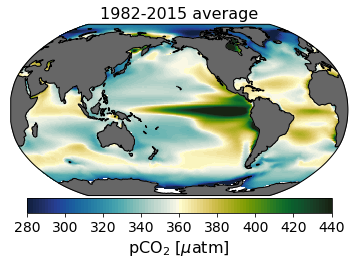

In [7]:
### Load in pCO2 from model
ds_pco2 = xr.open_dataset(f'{data_dir}/pCO2_2D_mon_CESM001_1x1_198201-201701.nc')

### Average over time and make a plot like l
data = ds_pco2['pCO2'].where(ds_pco2['pCO2']>0).mean('time')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds_pco2['xlon'], lat=ds_pco2['ylat'], 
                      fig=fig, rect=122, vrange=[280, 440], cmap=cm.cm.delta)
worldmap.set_ticks(220,440,20)
worldmap.set_cbar_title('pCO$_2$ [$\mu$atm]')
worldmap.set_title('1982-2015 average')

## Now let's sample the model like SOCAT and do the same thing
Notice that this looks alot like the average of the the real SOCAT data. This is because the model captures largescale features of the ocean (e.g. outgassing in the equatorial region and uptake in the North Atlantic).

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\co2\lib\site-packages\xarray\core\nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


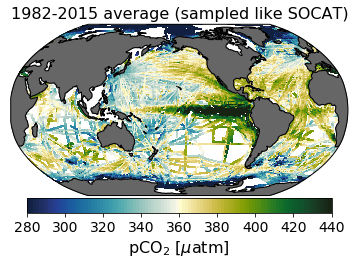

In [8]:
### Load in pCO2 from model
ds_pco2 = xr.open_dataset(f'{data_dir}/pCO2_2D_mon_CESM001_1x1_198201-201701.nc')

### Average over time and make a plot like l
data = ds_pco2['pCO2_socat'].where(ds_pco2['pCO2_socat']>0).mean('time')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds_pco2['xlon'], lat=ds_pco2['ylat'], 
                      fig=fig, rect=122, vrange=[280, 440], cmap=cm.cm.delta)
worldmap.set_ticks(220,440,20)
worldmap.set_cbar_title('pCO$_2$ [$\mu$atm]')
worldmap.set_title('1982-2015 average (sampled like SOCAT)')

# 2. What does the driver data look like?

Let's look at some of the driver data. I told you this is a state of the art model so it captures broadscale features

# 2.1 Sea surface tempeature

This is global average sea surface temperature. Pretty boring. Warm in the tropics and gets colder as you move to the poles. I can also look at SST at the SOCAT sites, but that doesn't really matter. It is these global maps that we are using a predictor

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\co2\lib\site-packages\xarray\core\nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


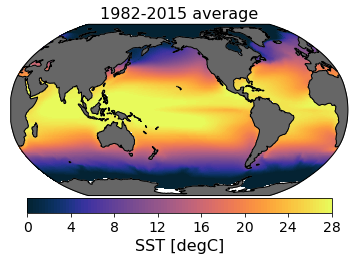

In [9]:
### Load in pCO2 from model
ds_sst = xr.open_dataset(f'{data_dir}/SST_2D_mon_CESM001_1x1_198201-201701.nc')

### Average over time and make a plot like l
data = ds_sst['SST'].mean('time')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds_sst['xlon'], lat=ds_sst['ylat'], 
                      fig=fig, rect=122, vrange=[0, 28], cmap=cm.cm.thermal)
worldmap.set_ticks(0,28,4)
worldmap.set_cbar_title('SST [degC]')
worldmap.set_title('1982-2015 average')

# 2.2 sea surface salinity salinity 

Well, this is interesting. There is higher salinity in the Atlantic than Pacific. Why is this? In a nutshell, it has to do with the size relative to the Pacific and that South America extends so far south. Spencer Jones (now a postdoc at Columbia's Lamont-Doherty Earth Obsevatory) has a nice paper on this: https://journals.ametsoc.org/doi/full/10.1175/JPO-D-17-0075.1

I do not expect you to read this, but if can if you are curious. 

Also, we are talking about seemily small changes in salinity. differences around 10 grams per kilogram, is significant and we can detect these changes from space!! I find that amazing!

But remember, what we are looking at here is a model. Let's not forget that.

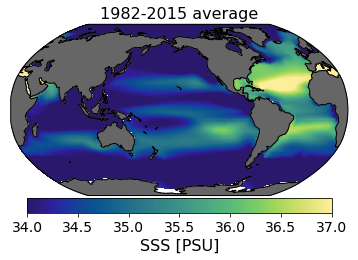

In [8]:
### Load in pCO2 from model
ds_sss = xr.open_dataset(f'{data_dir}/SSS_2D_mon_CESM001_1x1_198201-201701.nc')

### Average over time and make a plot like l
data = ds_sss['SSS'].mean('time')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds_sss['xlon'], lat=ds_sss['ylat'], 
                      fig=fig, rect=122, vrange=[34, 37], cmap=cm.cm.haline)
worldmap.set_ticks(34,37,0.5)
worldmap.set_cbar_title('SSS [PSU]')
worldmap.set_title('1982-2015 average')

# 2.3 chlorophyll

This is looks reasonable. Chlorophyll is a proxy for biological acitivity. Higher chlorophyll in North Atlantic where there are lots of diatoms and along the equatorial region where upwelling brings up nutrients and promotes algal growth

In the subtropics (where it's purple) there is little chlorophyll. We call these the "subropical deserts". Nutrients such as nitrate and phosphate are food for phytoplankton. They eat all there food really fast and there isn't a supply like there in the equatorial region. But some small pico-plankton can get by on little food.

This is the colormap that is in cmoceam. I am not a big fan of it. Sometimes I use `plt.cm.nipy_specral
`

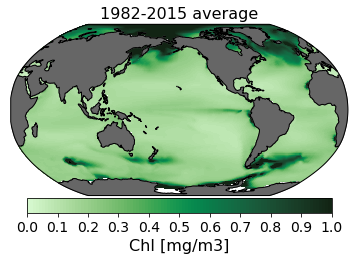

In [9]:
### Load in pCO2 from model
ds_chl = xr.open_dataset(f'{data_dir}/Chl_2D_mon_CESM001_1x1_198201-201701.nc')

### Average over time and make a plot like l
data = ds_chl['Chl'].mean('time')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds_chl['xlon'], lat=ds_chl['ylat'], 
                      fig=fig, rect=122, vrange=[0, 1], cmap=cm.cm.algae)
worldmap.set_ticks(0,1,0.1)
worldmap.set_cbar_title('Chl [mg/m3]')
worldmap.set_title('1982-2015 average')

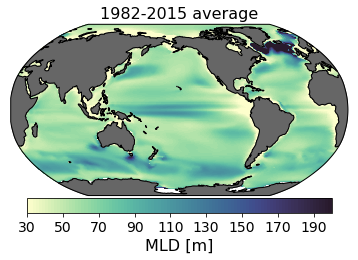

In [10]:
### Load in pCO2 from model
ds_mld = xr.open_dataset(f'{data_dir}/MLD_2D_mon_CESM001_1x1_198201-201701.nc')

### Average over time and make a plot like l
data = ds_mld['MLD'].mean('time')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds_mld['xlon'], lat=ds_mld['ylat'], 
                      fig=fig, rect=122, vrange=[30, 200], cmap=cm.cm.deep)
worldmap.set_ticks(30,200,20)
worldmap.set_cbar_title('MLD [m]')
worldmap.set_title('1982-2015 average')

# 2.4 atmospheric pCO2

This is the mixing ratio of atmospheric CO2. When you hear atmospheric concentration is 400 ppm, this is what they are referring to. The model assumes it's the same everywhere on the globe, there is no seasonal cycle, and there is a weird blip in 2005. Why is there a blip? Well, this a mistake that NCAR made. before 2005 they use historical data to estimate the concentration and after 2005 they make a guess on how the mixing ratio will increase. The worst case scenario (hopefully) is called RCP8.5 or the "business as usual" scenario. They were not careful when they meshed these two together so now we have this weird blip at 2005. :/

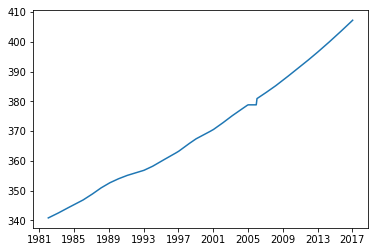

In [11]:
### Load in pCO2 from model
ds_xco2 = xr.open_dataset(f'{data_dir}/xCO2_1D_mon_CESM001_native_198201-201701.nc')
plt.plot(ds_xco2['time'], ds_xco2['XCO2'])

# 3 Let's predict pCO2 using this driver data

Now that we had a cursory look at out data. Let's make a model to predict it. Can we build a regression model that takes in these inputs and predicts pCO2?